In [78]:
#Importo dependencias
import scipy
import pandas as pd
import numpy as np
import math

In [79]:
#Importo parámetros
#Parámetros de la evolución química del sistema
tmax = 100e-6 #1.833973816e-010 // 1e5 //100e-6
R0 = 1e-6
Rmax = 1000e-6
T0 = 300
Tmax = 6000
sigmaT = 1e-6


#Parámetros químicos:
n_species = 8
n_reacc = 28
Na = 6.0221367e23 #defino el nro de avogadro

#Condiciones iniciales
#Orden:
#n[n_species] = {n[0],     n[1],   n[2],   n[3],   n[4],   n[5],   n[6],   n[7]}
#n[n_species] =      {H2,       H,      O,      O2,     OH,     H2O,    H2O2,   HO2}
#n0[n_species] = {0.0,   0.0,   0.5e8,    0.5e8,  0.0}
#n0 = np.array([1.0e8,   0.0,    0.0,    1.0e8,  0.0])
n0 = np.array([1.0e8,   0.0,    0.0,    1.0e8,  0.0,    1.0e8,    0.0,    0.0])
#Masas:
#masa de H: 1,00784 u (unidad de masa atómica)
#masa de O: 15,999 u
masa_H = 1.00784
masa_O = 15.999
masa_species = np.array([2*masa_H, masa_H, masa_O, 2*masa_O, masa_H + masa_O, 2*masa_H + masa_O, 2*masa_H + 2*masa_O, masa_H + 2*masa_O])

#Temporal integration control
# eps=1.0e-7;#error
# step=1.0e-11; #Time step [s]
# hmin=1.0e-16; #el paso minimo que debe tener en cuenta
# numciclos=1; #numero de ciclos que calcula NO USADO
epsilon=1.0e-6; #Convergence criterion para las cantidades que se calculan con el metodo de biseccion[1]. Lo necesito para, entre otras cosas, calcular m_punto.
# N=100; # cantidad de pasos utilizados para integrar la funcion error (ERF()). No lo uso porque en Python uso directamente la función math.erf() para calcular la función error.




#Parámetros para la condensación, evaporación y difusión

Rg=8.31451135945 #constante de los gases [J/gmol K]
#D2O
#Vapor Properties
a_h2o=0.5583 #constante de Van der Waals del agua [m6 Pa/mol]
b_h2o=3.0877e-5 #constante de Van der Waals del agua [m3/mol]
Mh2o=0.020 #masa molar del gas [kg/gmol]
#    Cvh2o=3.0*Rg #calor especifico a volumen constante del vapor de agua
#    k1h2o=-0.02028 #constantes de la conductividad del vapor [W/m K]
#    k2h2o=1.15006e-4
Rv=Rg/Mh2o #constante de los gases para el vapor de agua [J/kg K]
#    beta=1.0
#

#switches del modelo
rapidez=1 #switch utilizado para tomar a Gama como una funcion de mp, o como constante igual a uno. Si es 1 es rapido, otro numero y es lento

#Liquid-vapor properties
alfaM=0.1 #[1]#coeficiente de acomodacion

#
# Tinf=35+273.15 #D2O

# rol=1101.8 #densidad del liquido [kg/m3]
# mu=0.000869  #viscosidad [Pa s]
# cl=1415.1 #velocidad del sonido del liquido [m/s]
# cpl=4236.50#calor especifico del liquido [J/kg K]
# kl=0.60562#conductividad termica del agua [W/m K]
# sigma=0.07031  #tension superficial [J/m2]
# alfa=kl/cpl/rol
pvap0=4949 #este parámetro depende de T_nf y cambia si es D2O o H2O. Yo copié el de D2O. Es importante en la fórmual 2.2.1.4 para calcular m_punto
#

#Limits
# Tmin=200.0 #Minimum temperature para el calculo de biseccion [K]
# Tmax=20000.0 #Maximum temperature para el calculo de biseccion [K]
mpmin=-5.5e4 #Minimum mp para el calculo de biseccion [kg/m2 s]
mpmax=5.5e4 #Maximum mp para el calculo de biseccion [kg/m2 s]
# Cmin=0.0
# Cmax=4.0
# Rmax=1.0e-6


#Gas Properties - Argon
a_Ar=0.1345 #constante de Van der Waals del argon []
b_Ar=3.219e-5#constante de Van der Waals del argon []
# MAr=0.03942 #masa molar del argon [kg/gmol]
# CvAr=3.0/2.0*Rg #heat capacity at constant volume gas[J/kg K]
# k1Ar=0.009 #constantes de la conductividad del gas [W/m K]
# k2Ar=3.2e-5
# gama=Rg/(3.0*Rg)+1.0




In [80]:
#FUNCIONES QCAS

def R(t):
    return ((Rmax-R0)/tmax*t  + R0)

def V(t):
    return 4/3 * math.pi * R(t)**3

def dVdt(t):
    return 0
    #return 4*Pi*pow(R(t),2)*(Rmax-R0)/tmax;

def T(t):
    return (Tmax-T0)*np.exp(-0.5*pow(t/sigmaT,2)) + T0



In [81]:
#FUNCIONES MATH

def masa(n):
    #Calcula la masa total de las partículas dentro de la burbuja
    m = 0.0
    for i in range(n_species):
        m = m + n[i]*masa_species[i]
    return m

def imprimir_nro_particulas(n_species,n,t, m0):
    #Imprime el tiempo, el nro de partículas de cada especie y la masa normalizada a la masa inicial.
    print(t, "\t", n[0], "\t", n[1], "\t", n[2], "\t", n[3], "\t", n[4], "\t", n[5], "\t", n[6], "\t", n[7], "\t", masa(n)/m0)



def fact (n):
   return math.factorial(n)


def erf(omega):
   #Calcula la función error.

   #Antes pedía como argumentos (omega, int N) porque usaba N para hacer la aproximación de la integral.
   # double sum=0.0;
   # int i;
   # double valor;

   # if (fabs(omega)<4){
   #    for(i=0;i<=N;i++)
   #       sum=sum+pow(-1.0,i)*pow(omega,2.0*i+1.0)/((2.0*i+1.0)*fact(i));
   #    valor=2.0/sqrt(3.14159)*sum;
   # }
   # else {
   #    if(omega>=4)
   #       valor=1.0;
   #    if(omega<=-4)
   #       valor=-1.0;
   # }

   # return valor;

   return math.erf(omega)




In [82]:
#Calculo la masa inicial
m0 = masa(n0)

In [83]:
def lista_de_reacciones(t, n, r):
    #Para dado t y n, calcula los términos de dndt debido a las reacciones qcas y los carga en r.

    ntot = 0.0
    for i in range(n_species):
        ntot = ntot + n[i]

    MolCov=5.1e-29; #molecular covolumen [m^3]
    VolExcl=np.exp(ntot/V(t)*MolCov/(1.0-ntot/V(t)*MolCov))/(1.0-ntot/V(t)*MolCov)

    #Parametros de disociacion.
    #Son empleados para calcular los cambios debido a las reacciones. Creo que los que no están presentados son todos 0.
    t1=1.0
    t2=1.0
    t5=1.0
    t6=1.0
    t15=-1.0
    t16=1.0
    t33=-1.0
    t34=-1.0
    t39=1.0

    #Cargo las reacciones: par es forward, impar es backwards.

    #Reacción 1: O + O + M -> O2 + M
    r[0]=pow(VolExcl,t1)*1.2e17*(1.0e-12)*(ntot/V(t))*(n[2]/V(t))*(n[2]/V(t))*pow(T(t),-1.0)*np.exp(-0.0/T(t))/Na/Na
    r[1]=3.16e19*(1.0e-6)*(ntot/V(t))*(n[3]/V(t))*pow(T(t),-1.3)*np.exp(-59893.0/T(t))/Na

    #Reacción 2: O + H + M -> OH + M
    r[2]=pow(VolExcl,t2)*5.0e17*(1.0e-12)*(ntot/V(t))*(n[2]/V(t))*(n[1]/V(t))*pow(T(t),-1.0)*np.exp(-0.0/T(t))/Na/Na
    r[3]=3.54e17*(1.0e-6)*(ntot/V(t))*(n[4]/V(t))*pow(T(t),-0.9)*np.exp(-51217.0/T(t))/Na

    #Reacción 3: O + H2 -> H + OH
    r[4]=3.87e4*(1.0e-6)*(n[2]/V(t))*(n[0]/V(t))*pow(T(t),2.7)*np.exp(-3150.0/T(t))/Na
    r[5]=1.79e4*(1.0e-6)*(n[1]/V(t))*(n[4]/V(t))*pow(T(t),2.7)*np.exp(-2200.0/T(t))/Na

    #Reacción 4: H + O2 -> O +OH
    r[6]=2.65e16*(1.0e-6)*(n[1]/V(t))*(n[3]/V(t))*pow(T(t),-0.7)*np.exp(-8576.0/T(t))/Na
    r[7]=9.0e13*(1.0e-6)*(n[2]/V(t))*(n[4]/V(t))*pow(T(t),-0.3)*np.exp(83.0/T(t))/Na

    #Reacción 5: H + H + M -> H2 + M
    r[8]=pow(VolExcl,t5)*1.0e18*(1.0e-12)*(ntot/V(t))*(n[1]/V(t))*(n[1]/V(t))*pow(T(t),-1.0)*np.exp(-0.0/T(t))/Na/Na
    r[9]=7.46e17*(1.0e-6)*(ntot/V(t))*(n[0]/V(t))*pow(T(t),-0.8)*np.exp(-52177.0/T(t))/Na

    #Reacción 6: H + OH + M -> H2O + M
    r[10]=pow(VolExcl,t6)*2.2e22*(1.0e-12)*(ntot/V(t))*(n[1]/V(t))*(n[4]/V(t))*pow(T(t),-2.0)*np.exp(-0.0/T(t))/Na/Na
    r[11]=3.67e23*(1.0e-6)*(ntot/V(t))*(n[5]/V(t))*pow(T(t),-2.0)*np.exp(-59980.0/T(t))/Na

    #Reacción 7: OH + H2 -> H + H2O
    r[12]=2.16e8*(1.0e-6)*(n[4]/V(t))*(n[0]/V(t))*pow(T(t),1.5)*np.exp(-1726.0/T(t))/Na
    r[13]=5.2e9*(1.0e-6)*(n[1]/V(t))*(n[5]/V(t))*pow(T(t),1.3)*np.exp(-9529.0/T(t))/Na

    #Reacción 8: OH + OH -> O + H2O
    r[14]=3.57e4*(1.0e-6)*(n[4]/V(t))*(n[4]/V(t))*pow(T(t),2.4)*np.exp(-1062.0/T(t))/Na
    r[15]=1.74e6*(1.0e-6)*(n[2]/V(t))*(n[5]/V(t))*pow(T(t),2.2)*np.exp(-7693.0/T(t))/Na

    #Reacción 46: antes numeradas 90 y 91: HO2 + HO2 -> H2O2 + O2
    r[16]=3.0e12*(1.0e-6)*(n[7]/V(t))*(n[7]/V(t))*pow(T(t),0.0)*np.exp(-700.0/T(t))/Na
    r[17]=4.53e14*(1.0e-6)*(n[6]/V(t))*(n[3]/V(t))*pow(T(t),-0.39)*np.exp(-19700.0/T(t))/Na

    #Reacción 47: antes numeradas 92 y 93: H2O2 -> OH + OH
    r[18]=1.2e17*(1.0e-6)*(n[6]/V(t))*(ntot/V(t))*pow(T(t),0.0)*np.exp(-22900.0/T(t))/Na
    r[19]=9.0e5*(1.0e-12)*(ntot/V(t))*(n[4]/V(t))*(n[4]/V(t))*pow(T(t),0.9)*np.exp(3050.0/T(t))/Na/Na

    #Reacción 48: antes numeradas 94 y 95: H2O2 + H -> H2O + OH
    r[20]=3.2e14*(1.0e-6)*(n[6]/V(t))*(n[1]/V(t))*pow(T(t),0.0)*np.exp(-4510.0/T(t))/Na
    r[21]=1.14e9*(1.0e-6)*(n[5]/V(t))*(n[4]/V(t))*pow(T(t),1.36)*np.exp(-38180.0/T(t))/Na

    #Reacción 49: antes numeradas 96 y 97: H2O2 + H -> H2 + HO2
    r[22]=4.82e13*(1.0e-6)*(n[6]/V(t))*(n[1]/V(t))*pow(T(t),0.0)*np.exp(-4000.0/T(t))/Na
    r[23]=1.41e11*(1.0e-6)*(n[0]/V(t))*(n[7]/V(t))*pow(T(t),0.66)*np.exp(-12320.0/T(t))/Na

    #Reacción 50: antes numeradas 98 y 99: H2O2 + O -> OH + HO2
    r[24]=9.55e6*(1.0e-6)*(n[6]/V(t))*(n[2]/V(t))*pow(T(t),2.0)*np.exp(-2000.0/T(t))/Na
    r[25]=4.62e3*(1.0e-6)*(n[4]/V(t))*(n[7]/V(t))*pow(T(t),2.75)*np.exp(-9277.0/T(t))/Na

    #Reacción 51: antes numeradas 100 y 101: H2O2 + OH -> H2O + HO2
    r[26]=1.00e13*(1.0e-6)*(n[6]/V(t))*(n[4]/V(t))*pow(T(t),0.0)*np.exp(-900.0/T(t))/Na
    r[27]=2.8e13*(1.0e-6)*(n[5]/V(t))*(n[7]/V(t))*pow(T(t),0.0)*np.exp(-16500.0/T(t))/Na

def reacciones_qcas(t, n, dndt):
    #Considera el efecto de todas las reacciones qcas sobre la derivada dndt
    r = np.zeros(n_reacc)
    lista_de_reacciones(t, n, r)

    # //1 reacción:
    # dndt[0]=0
    # dndt[1]=0
    # dndt[2]=V(t)*(-2.0*(r[0]-r[1]))
    # dndt[3]=V(t)*(1.0*(r[0]-r[1]))
    # dndt[4]=0

    # //3 reacciones:
    # dndt[0]=V(t)*(-1.0*(r[4]-r[5]))
    # dndt[1]=V(t)*(-1.0*(r[2]-r[3])+1.0*(r[4]-r[5]))
    # dndt[2]=V(t)*(-2.0*(r[0]-r[1])-1.0*(r[2]-r[3])-1.0*(r[4]-r[5]))
    # dndt[3]=V(t)*(1.0*(r[0]-r[1]))
    # dndt[4]=V(t)*(+1.0*(r[2]-r[3])+1.0*(r[4]-r[5]))

    # //Todas las reacciones que no involucran N (Nitrógeno):
    # //n[0] = y[Nvar2+1] =H2.
    # //n[1] = y[Nvar2+2] =H
    # //n[2] = y[Nvar2+3] =O
    # //n[3] = y[Nvar2+4] =O2
    # //n[4] = y[Nvar2+5] =OH
    # //n[5] = y[Nvar2+6] =H2O = y[4] = vapor
    # //n[6] = y[Nvar2+18] =H2O2. Este es mi n[6]
    # //n[7] = y[Nvar2+19] =HO2

    dndt[0] = dndt[0] + V(t)*(-1.0*(r[4]-r[5])+1.0*(r[8]-r[9])-1.0*(r[12]-r[13])+1.0*(r[22]-r[23]))
    dndt[1] = dndt[1] + V(t)*(-1.0*(r[2]-r[3])+1.0*(r[4]-r[5])-1.0*(r[6]-r[7])-2.0*(r[8]-r[9])-1.0*(r[10]-r[11])+1.0*(r[12]-r[13])-1.0*(r[20]-r[21])-1.0*(r[22]-r[23]))
    dndt[2] = dndt[2] + V(t)*(-2.0*(r[0]-r[1])-1.0*(r[2]-r[3])-1.0*(r[4]-r[5])+1.0*(r[6]-r[7])+1.0*(r[14]-r[15])-1.0*(r[24]-r[24]))
    dndt[3] = dndt[3] + V(t)*(1.0*(r[0]-r[1])-1.0*(r[6]-r[7])+1.0*(r[16]-r[17]))
    dndt[4] = dndt[4] + V(t)*(+1.0*(r[2]-r[3])+1.0*(r[4]-r[5])+1.0*(r[6]-r[7])-1.0*(r[10]-r[11])-1.0*(r[12]-r[13])-2.0*(r[14]-r[15])+2.0*(r[18]-r[19])+1.0*(r[20]-r[21])+1.0*(r[24]-r[24]))
    dndt[5] = dndt[5] + V(t)*(+1.0*(r[10]-r[11])+1.0*(r[12]-r[13])+1.0*(r[14]-r[15])+ 1.0*(r[20]-r[21])+1.0*(r[26]-r[27]))
    dndt[6] = dndt[6] + V(t)*(-1.0*(r[18]-r[19])-1.0*(r[20]-r[21])-1.0*(r[22]-r[23])-1.0*(r[24]-r[24])-1.0*(r[26]-r[27])+1.0*(r[16]-r[17]))
    dndt[7] = dndt[7] + V(t)*(-2.0*(r[16]-r[17])+1.0*(r[22]-r[23])+1.0*(r[24]-r[24])+1.0*(r[26]-r[27]))

    return


In [84]:
#Función que calcula m_punto.

def TLi(t):
   #Temperatura del líquido en la interfase.
   return 300 #A priori considero que es aproximadamente la temperatura ambiente

def T_unknown(t):
   #Temperatura "T" que aparece en la expresión 2.2.1.7 para calcular Gamma
   return T(t) #A priori considero que es igual a la temperatura T(t)

def TB(t):
   return T(t)

def calculamp_formal(mpmin,mpmax,epsilon, pvap, pv,T,TLi,TB):
   # Calcula m_punto formalmente a partir de la expresión 2.2.1.3 considerando varios factores como entrada
   # mpmin y mpmax son parámetros mínimos y máximos para el cálculo por bisección. Están definidos en Parámetros
   # epsilon es la tolerancia para el cálculo por bisección. Está definida en Parámetros
   # pvap es la presión de vapor saturado a la temperatura del líquido en la interfase T_{L,i}. Está definida en parámetros
   # pv es la presión parcial correspondiente al vapor
   # T ((creo que es la temperatura de la burbuja))
   # TLi es la temperatura del líquido en la interfase
   # TB es la temperatura de la mezcla en la superficie de la burbuja

   if(alfaM > 0):
      while ((mpmax-mpmin)>epsilon):
         #mp es la resta de los mp de evaporacion y de condensacion
         Omega=mpmax/pv*math.sqrt(Rv*T/2.0)
         Gama=np.exp(-Omega*Omega)-Omega*math.sqrt(3.14159)*(1.0-erf(Omega))
         f1=mpmax-alfaM/math.sqrt(2.0*3.14159*Rv)*(pvap/math.sqrt(TLi)-Gama*pv/math.sqrt(TB))

         x=(mpmin+mpmax)/2.0

         Omega=x/pv*math.sqrt(Rv*T/2.0)
         Gama=np.exp(-Omega*Omega)-Omega*math.sqrt(3.14159)*(1.0-erf(Omega))

         f3=x-alfaM/math.sqrt(2.0*3.14159*Rv)*(pvap/math.sqrt(TLi)-Gama*pv/math.sqrt(TB))

         if(f1*f3>0):
            mpmax=x
         else:
            mpmin=x
      #fin del while

      return x
      #devuelve el valor de mp como la raiz de la ecuacion trascendente con tolerancia epsilon
   #fin del if
   else:
      x=0
      return x

def n_tot(n):
   #Función que calcula el número total de partículas de una mezcla
   suma = 0
   for i in range(n_species):
      suma = suma + n[i]
   return suma

def ctes_VanderWaals(ngas, nvap, ntot):
   #Calculo las ctes de Van de Waals a partir de las ecs 2.2.2.2 y 2.2.2.3
   #ngas = ng es la cantidad de partículas de gas no condensable
   #nvap = nv es la cantidad de partículas de vapor (h2o)
   #ntot = nt es la cantidad de partículas totales.

   a_g = a_Ar
   b_g = b_Ar

   a_v = a_h2o
   b_v = b_h2o

   a_gv = math.sqrt(a_g*a_v) #VW gas-vapor a_{g-v}. Antes se llamaba a_Arh2o
   b_gv = pow(0.5*(pow(b_g,1.0/3.0)+pow(b_v,1.0/3.0)),3.0) #VW gas-vapor b_{g-v}. Antes se llamaba b_Arh2o


   a = a_g*(ngas/ntot)**2 + 2.0*a_gv*(ngas/ntot)*(nvap/ntot)+ a_v*(nvap/ntot)*(nvap/ntot) #const a de VW promediada con la cantidad de particulas
   b = b_g*(ngas/ntot)**2 + 2.0*b_gv*(ngas/ntot)*(nvap/ntot)+ b_v*(nvap/ntot)*(nvap/ntot) #const b de VW promediada con la cantidad de particulas

   return a,b

def volumen_molar(V, ntot):
   # Calcula el volumen molar, necesario en el cálculo de la presión del gas empleando la ec. de Van der Waals.
   # V es el volumen total
   # ntot es el nro total de partículas
   # Na es el nro de Avogadro
   v=V/ntot*Na #volumen molar
   return v

def calculamp(t , n_h2o, ntot, rapidez):
   # Calcula m_punto a partir de la expresión 2.2.1.3. Calcula también las variables necesarias para hacer la cuenta
   # t es el tiempo. Se usa para calcular V(t), T(t), T_unknown(t). En el caso gral debería sacar esto
   # n_h2o es la cantidad de partículas de h2o
   # ntot es la cantidad de partículas totales
   # rapidez indica si se quiere hacer la cuenta rápido o lento. Esencialmente, lo único que cambia es si va a calcular la función error o no.
   # TB es la temperatura de la mezcla en la superficie de la burbuja
   
   #Nro de partículas de gas no condensable.
   ngas=ntot-n_h2o

   #Calculo las constantes de Van der Waals:
   a,b = ctes_VanderWaals(ngas, n_h2o, ntot)
   v = volumen_molar(V(t), ntot) #volumen molar

   #Presion del gas calculada a partir de 2.2.2.1 empleando la ec. de Van der Waals.
   pg=Rg*T_unknown(t)/(v-b)-a/(v*v)

   #NO SÉ LO QUE ES ESTO NI SIQUIERA SI SE USA:
   pgg=ngas/ntot*pg

   pvap=pvap0 #parámetro definido en Parámetros

   #Presion parcial del vapor de agua. Se calcula con 2.2.1.6 a partir del nro de partículas de vapor (agua), el nro total de partículas y la presión total dentro de la burbuja
   pv=n_h2o/ntot*pg 

   #Calculo TB:
   if(modelo == 1)
      TB = calculaTBY(Tmin,Tmax,epsilon,y[5],k,landa,np,y[3],m);


   #Hago el cálculo de mp dependiendo del parámetro rapidez. Esto afecta en la rapidez del cálculo
   if(rapidez==1):
      TLi_ = TLi(t) #tengo que hacer esto para que la función math.sqrt() tenga como argumento un nro y no una función TLi(t).
      mp=alfaM/math.sqrt(2.0*3.14159*Rv)*(pvap/math.sqrt(TLi_)-pv/math.sqrt(TB))
   else:
      mp=calculamp(mpmin,mpmax,epsilon,pvap,pv,T_unknown(t),TLi(t),TB)
   
   return mp


In [ ]:
#Modelos para calcular TB.

#metodo de Toegel
# double calculaTBT(double Tmin,double Tmax,double epsilon,double TLi,double k,
#                   double lth,double np,double T,double m){

#  //Para hacer biseccion usa un Tmin y un Tmax, a partir de los cuales hace los calculos
#  //epsilon es la tolerancia para encontrar la raiz por el metodo de biseccion
#  //TLi es la temperatura en la pared de la burbuja del lado externo
#  //k es la conductividad que depende de la temperatura
#  //landa es una funcion que depende de la temperatura
#  //np es la densidad de numero de moleculas
#  //T es la temperatura en el interior de la burbuja

#  extern double ap,alfae,K,n,Tinf; //El nodo parametros.cpp tiene que es c/u de estos valores

#  double f1,f3,x;


#  while((Tmax-Tmin)>epsilon){

#   f1=Tmax-TLi+1.0/(2.0*K*np)*sqrt(3.14159*m/(2.0*K*Tmax))*(2.0-ap*alfae)/alfae*k*(Tinf-T)/(lth);

#   x=(Tmax+Tmin)/2.0;

#   f3=x-TLi+1.0/(2.0*K*np)*sqrt(3.14159*m/(2.0*K*x))*(2.0-ap*alfae)/alfae*k*(Tinf-T)/(lth);


#   if(f1*f3>0){
# 	Tmax=x;
#   }
#   else{
# 	Tmin=x;
#   }


#  }

# 	return x;


# }


#metodo de Yasui
def calculaTBY(Tmin, Tmax, epsilon, TLi, k, landa, np, T, m):
  #Para hacer biseccion usa un Tmin y un Tmax, a partir de los cuales hace los calculos
  #epsilon es la tolerancia para encontrar la raiz por el metodo de biseccion
  #TLi es la temperatura en la pared de la burbuja del lado externo
  #k es la conductividad que depende de la temperatura
  #landa es una funcion que depende de la temperatura
  #np es la densidad de numero de moleculas
  #T es la temperatura en el interior de la burbuja

  extern ap,alfae,K,n,Tinf #El nodo parametros.cpp tiene que es c/u de estos valores

  f1,f3,x


  while((Tmax-Tmin)>epsilon){

  f1=Tmax-TLi+1.0/(2.0*K*np)*sqrt(3.14159*m/(2.0*K*Tmax))*(2.0-ap*alfae)/alfae*k*(Tmax-T)/(n*landa)

  x=(Tmax+Tmin)/2.0

  f3=x-TLi+1.0/(2.0*K*np)*sqrt(3.14159*m/(2.0*K*x))*(2.0-ap*alfae)/alfae*k*(x-T)/(n*landa)


  if(f1*f3>0){
  Tmax=x
  }
  else{
  Tmin=x
  }


  }
  return x




# //metodo de Ha0-Prosperetti
# double calculaTBHP(double Tmin,double Tmax,double epsilon,double TLi,double qpp,
#                    double np,double m){

#  //Para hacer biseccion usa un Tmin y un Tmax, a partir de los cuales hace los calculos
#  //epsilon es la tolerancia para encontrar la raiz por el metodo de biseccion
#  //TLi es la temperatura en la pared de la burbuja del lado externo
#  //k es la conductividad que depende de la temperatura
#  //landa es una funcion que depende de la temperatura
#  //np es la densidad de numero de moleculas
#  //T es la temperatura en el interior de la burbuja

#  extern double ap,alfae,K,n,Tinf; //El nodo parametros.cpp tiene que es c/u de estos valores

#  double f1,f3,x;


#  while((Tmax-Tmin)>epsilon){

#   f1=Tmax-TLi+1.0/(2.0*K*np)*sqrt(3.14159*m/(2.0*K*Tmax))*(2.0-ap*alfae)/alfae*qpp;

#   x=(Tmax+Tmin)/2.0;

#   f3=x-TLi+1.0/(2.0*K*np)*sqrt(3.14159*m/(2.0*K*x))*(2.0-ap*alfae)/alfae*qpp;


#   if(f1*f3>0){
# 	Tmax=x;
#   }
#   else{
# 	Tmin=x;
#   }


#  }

# 	return x;


# }


In [85]:
def condensacion(t,n, dndt):
    #Calcula el efecto de la condensación y evaporación. No el efecto de la difusión (2do término de 2.2.3.1)
    #Lo incorpora a dndt (solo al vapor H2O)
    #t es el tiempo necesario para calcular R(t), V(t) y T(t)


    mp = calculamp(t , n[5], n_tot(n), rapidez)

    dndt[5]= dndt[5] + 4.0*math.pi*(R(t)**2)*(mp*Na/Mh2o) #variacion de la cantidad de particulas
    #de vapor de agua debido a la condensacion, mas por difusion y reacciones quimicas
    #(CREO QUE NO ESTÁ CONTENIDA LA DIFUSIÓN)

    return 

In [86]:

def derivada(t, n):
    #Calculo la derivada dndt
    dndt = np.zeros(n_species)

    #Considero que ocuren reacciones qcas
    reacciones_qcas(t,n,dndt)
    condensacion(t,n,dndt)

    imprimir_nro_particulas(n_species,n,t, m0)

    
    return dndt

In [87]:


#Creo el vector de nro de partículas y lo inicializo
n = np.zeros(n_species)
for i in range(n_species):
    n[i] = n0[i]


t0=0.0; #Inicializacion del tiempo
    
#Creo el vector de dndt y lo inicializo
dndt = np.zeros(n_species)
dndt = derivada(t0, n)



    # //Creo el file en el que voy a ir guardando todo
    # ofstream file(archivo);
    # file << encabezado << endl;

imprimir_nro_particulas(n_species, n, t0, m0) #imprimo la cantidad inicial de partículas de cada especie
#step es el htry, es decir, el salto que (intenta hacer?) el rkqc.

#-------------------------------------------------------------------------------------------------------------------------
#SOLUCIÓN NUMÉRICA EMPLEANDO EL MÉTODO Radau
soln = solve_ivp(derivada, [t0, tmax], n0, method='Radau')


0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
1.7300105521701416e-21 	 99999999.99999756 	 1.4428216613921608e-05 	 7.36633287126567e-07 	 99999999.99999963 	 9.554262752094149e-06 	 99999999.99995773 	 0.0 	 0.0 	 0.9999999999998868
0.0 	 99999998.50988388 	 0.0 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 0.9999999994227
0.0 	 100000000.0 	 1.4901161193847656e-14 	 0.0 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 1.4901161193847656e-14 	 100000000.0 	 0.0 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 99999998.50988388 	 0.0 	 100000000.0 	 0.0 	 0.0 	 0.9999999908356259
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 1.4901161193847656e-14 	 100000000.0 	 0.0 	 0.0 	 1.0
0.0 	 100000000.0 	 0.0 	 0.0 	 100000000.0 	 0.0 	 99999998

In [89]:
print(soln) #para obtener info. sobre cómo fue la integración numérica

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 762
     njev: 35
      nlu: 162
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.73001055e-19, 1.90301161e-18, 1.92031171e-17,
       1.92204172e-16, 1.92221472e-15, 1.92223202e-14, 1.92223375e-13,
       7.73562072e-13, 1.80429253e-12, 3.44068584e-12, 5.89127781e-12,
       9.53891021e-12, 1.52040657e-11, 2.50388031e-11, 4.68117690e-11,
       1.01641254e-10, 1.71174030e-10, 2.92221006e-10, 4.87160000e-10,
       8.19349842e-10, 1.42975535e-09, 1.89586130e-09, 2.89369266e-09,
       3.43546355e-09, 4.56826111e-09, 5.85596046e-09, 7.44257983e-09,
       9.77951362e-09, 1.27911413e-08, 1.59669375e-08, 2.09420516e-08,
       2.62645481e-08, 3.36141856e-08, 4.19114497e-08, 5.33390495e-08,
       6.46303641e-08, 8.24522304e-08, 1.03102593e-07, 1.30031450e-07,
       1.66165204e-07, 2.15303305e-07, 2.56534544e-07, 3.17559442e-07,
       3.83141265e-07, 4.37854465e-07

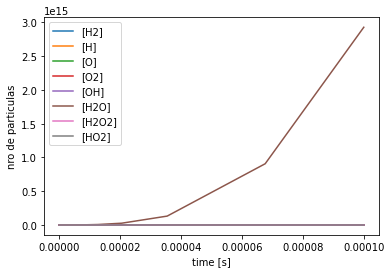

In [90]:
#plt.figure(dpi=1200) #Para mayor resolución
plt.plot(soln.t, soln.y[0], label='[H2]')
plt.plot(soln.t, soln.y[1], label='[H]')
plt.plot(soln.t, soln.y[2], label='[O]')
plt.plot(soln.t, soln.y[3], label='[O2]')
plt.plot(soln.t, soln.y[4], label='[OH]')
plt.plot(soln.t, soln.y[5], label='[H2O]')
plt.plot(soln.t, soln.y[6], label='[H2O2]')
plt.plot(soln.t, soln.y[7], label='[HO2]')
plt.xlabel('time [s]')
plt.ylabel('nro de particulas')
plt.legend()
plt.show()

